In [93]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from xgboost import XGBRegressor, plot_importance


In [94]:
# load data
df = pd.read_csv("C:/Users/gadda/Downloads/GlobalWeatherRepository.csv")

In [95]:
df.head() # preview first few rows

,country,location_name,latitude,longitude,timezone,last_updated_epoch,last_updated,temperature_celsius,temperature_fahrenheit,condition_text,...,air_quality_PM2.5,air_quality_PM10,air_quality_us-epa-index,air_quality_gb-defra-index,sunrise,sunset,moonrise,moonset,moon_phase,moon_illumination
0,Afghanistan,Kabul,34.52,69.18,Asia/Kabul,1715849100,2024-05-16 13:15,26.6,79.8,Partly Cloudy,...,8.4,26.6,1,1,04:50 AM,06:50 PM,12:12 PM,01:11 AM,Waxing Gibbous,55
1,Albania,Tirana,41.33,19.82,Europe/Tirane,1715849100,2024-05-16 10:45,19.0,66.2,Partly cloudy,...,1.1,2.0,1,1,05:21 AM,07:54 PM,12:58 PM,02:14 AM,Waxing Gibbous,55
2,Algeria,Algiers,36.76,3.05,Africa/Algiers,1715849100,2024-05-16 09:45,23.0,73.4,Sunny,...,10.4,18.4,1,1,05:40 AM,07:50 PM,01:15 PM,02:14 AM,Waxing Gibbous,55
3,Andorra,Andorra La Vella,42.50,1.52,Europe/Andorra,1715849100,2024-05-16 10:45,6.3,43.3,Light drizzle,...,0.7,0.9,1,1,06:31 AM,09:11 PM,02:12 PM,03:31 AM,Waxing Gibbous,55
4,Angola,Luanda,-8.84,13.23,Africa/Luanda,1715849100,2024-05-16 09:45,26.0,78.8,Partly cloudy,...,183.4,262.3,5,10,06:12 AM,05:55 PM,01:17 PM,12:38 AM,Waxing Gibbous,55


In [96]:
df.info() # check column types and null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91782 entries, 0 to 91781
Data columns (total 41 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   country                       91782 non-null  object 
 1   location_name                 91782 non-null  object 
 2   latitude                      91782 non-null  float64
 3   longitude                     91782 non-null  float64
 4   timezone                      91782 non-null  object 
 5   last_updated_epoch            91782 non-null  int64  
 6   last_updated                  91782 non-null  object 
 7   temperature_celsius           91782 non-null  float64
 8   temperature_fahrenheit        91782 non-null  float64
 9   condition_text                91782 non-null  object 
 10  wind_mph                      91782 non-null  float64
 11  wind_kph                      91782 non-null  float64
 12  wind_degree                   91782 non-null  int64  
 13  w

In [97]:
# change last updated to datetime
# there are no nulls
df['last_updated'] = pd.to_datetime(df['last_updated'])


In [98]:
# preprocessing --> drop redudant columns

drop_cols = [
    "moon_phase", "sunrise", "sunset", "moonrise", "moonset", "moon_illumination",
    "last_updated_epoch", "location_name", "condition_text",
    "temperature_celsius", "feels_like_celsius", "gust_kph", "visibility_km",
    "precip_in"
]

df.drop(columns=drop_cols, inplace=True)



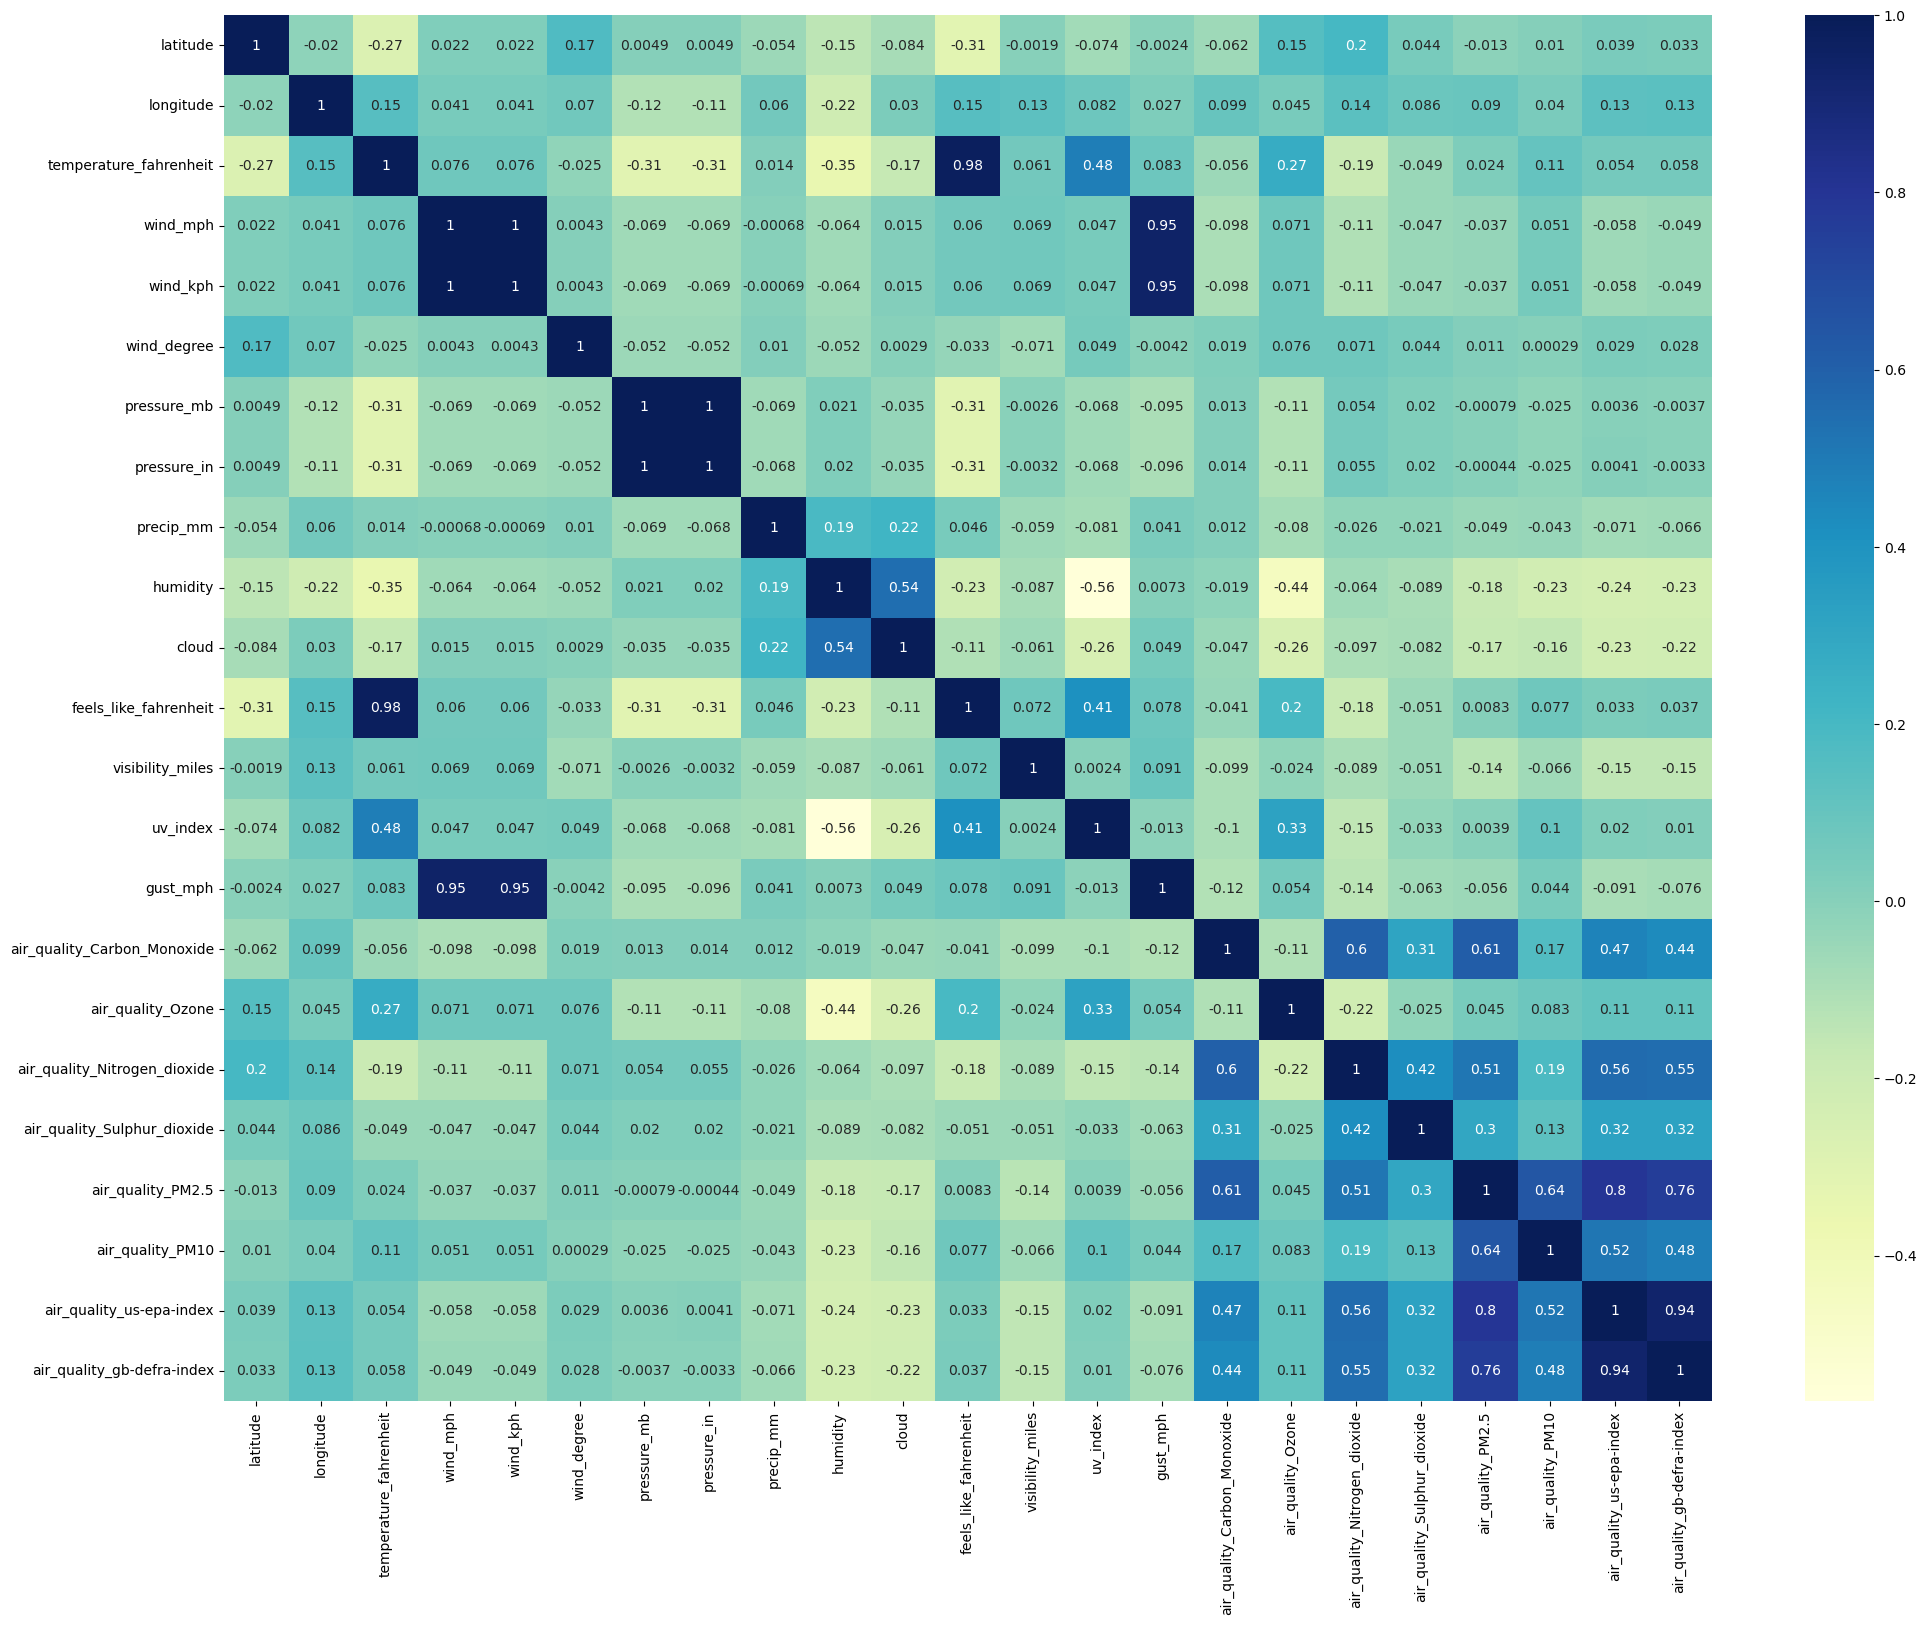

In [99]:
# correlation heatmap
plt.figure(figsize=(24, 18))
co_mtx = df.corr(numeric_only=True)
sns.heatmap(co_mtx, cmap="YlGnBu", annot=True)
plt.show()

In [100]:
# most correlated with temp (and relevant): humidity, cloud, ait quality ozone, uv index, pressure

drop_cols2 = ["wind_kph", "pressure_mb", 
              "wind_direction",  "air_quality_Carbon_Monoxide", "wind_mph", 
              "feels_like_fahrenheit", "wind_degree", 
              "air_quality_Nitrogen_dioxide", "air_quality_Sulphur_dioxide",
              "air_quality_PM2.5", "air_quality_PM10", "air_quality_us-epa-index",
              "air_quality_gb-defra-index", "gust_mph", "visibility_miles"]
df.drop(columns=drop_cols2, inplace=True)


In [101]:
df['last_updated'] = pd.to_datetime(df['last_updated'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91782 entries, 0 to 91781
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   country                 91782 non-null  object        
 1   latitude                91782 non-null  float64       
 2   longitude               91782 non-null  float64       
 3   timezone                91782 non-null  object        
 4   last_updated            91782 non-null  datetime64[ns]
 5   temperature_fahrenheit  91782 non-null  float64       
 6   pressure_in             91782 non-null  float64       
 7   precip_mm               91782 non-null  float64       
 8   humidity                91782 non-null  int64         
 9   cloud                   91782 non-null  int64         
 10  uv_index                91782 non-null  float64       
 11  air_quality_Ozone       91782 non-null  float64       
dtypes: datetime64[ns](1), float64(7), int64(2), ob

In [102]:
df.head()

,country,latitude,longitude,timezone,last_updated,temperature_fahrenheit,pressure_in,precip_mm,humidity,cloud,uv_index,air_quality_Ozone
0,Afghanistan,34.52,69.18,Asia/Kabul,2024-05-16 13:15:00,79.8,29.89,0.0,24,30,7.0,103.0
1,Albania,41.33,19.82,Europe/Tirane,2024-05-16 10:45:00,66.2,29.88,0.1,94,75,5.0,97.3
2,Algeria,36.76,3.05,Africa/Algiers,2024-05-16 09:45:00,73.4,29.85,0.0,29,0,5.0,12.2
3,Andorra,42.50,1.52,Europe/Andorra,2024-05-16 10:45:00,43.3,29.75,0.3,61,100,2.0,64.4
4,Angola,-8.84,13.23,Africa/Luanda,2024-05-16 09:45:00,78.8,29.85,0.0,89,50,8.0,19.0


In [103]:
# Filter to USA data and resample daily

df_country = df[df['country'] == 'United States of America']
df_country = df_country.sort_values('last_updated')
# select numeric columns
numeric_cols = df_country.select_dtypes(include='number').columns

# Daily resampling (mean of each day)
df_daily = (
    df_country
    .set_index('last_updated')[numeric_cols]  # only numeric data
    .resample('D')
    .mean()
)

df_daily.head()

,latitude,longitude,temperature_fahrenheit,pressure_in,precip_mm,humidity,cloud,uv_index,air_quality_Ozone
last_updated,,,,,,,,,
2024-05-16,46.6,-120.49,60.55,29.865,0.0,56.5,0.0,2.5,49.15
2024-05-17,46.6,-120.49,55.90,30.000,0.0,31.0,0.0,4.0,85.80
2024-05-18,46.6,-120.49,48.00,30.010,0.0,63.0,100.0,3.0,50.10
2024-05-19,46.6,-120.49,46.00,30.080,0.0,63.0,0.0,3.0,64.40
2024-05-20,46.6,-120.49,48.90,30.150,0.0,59.0,0.0,3.0,57.90


# Exploratory Plots

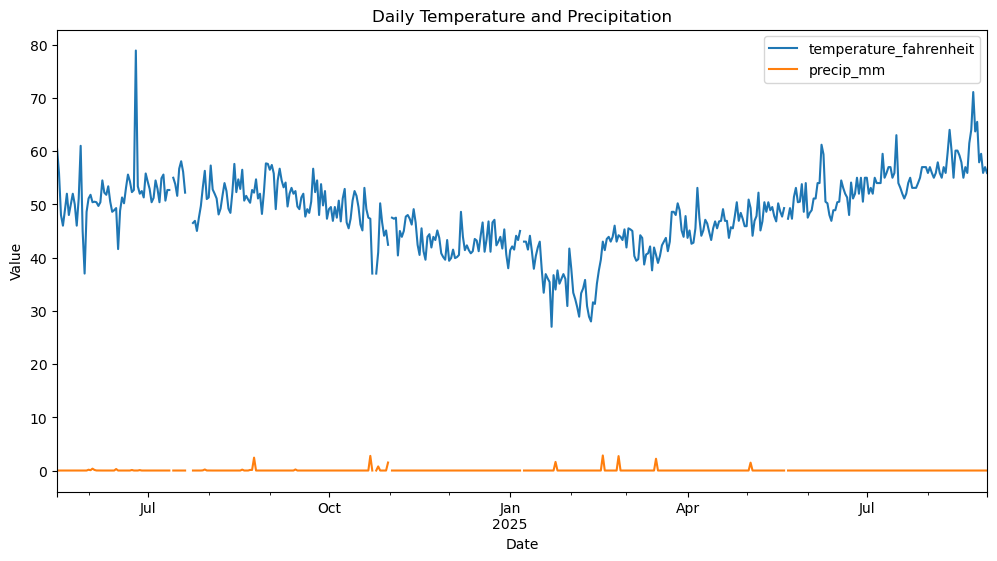

In [104]:

df_daily[['temperature_fahrenheit', 'precip_mm']].plot(figsize=(12,6))
plt.title("Daily Temperature and Precipitation")
plt.ylabel("Value")
plt.xlabel("Date")
plt.show()


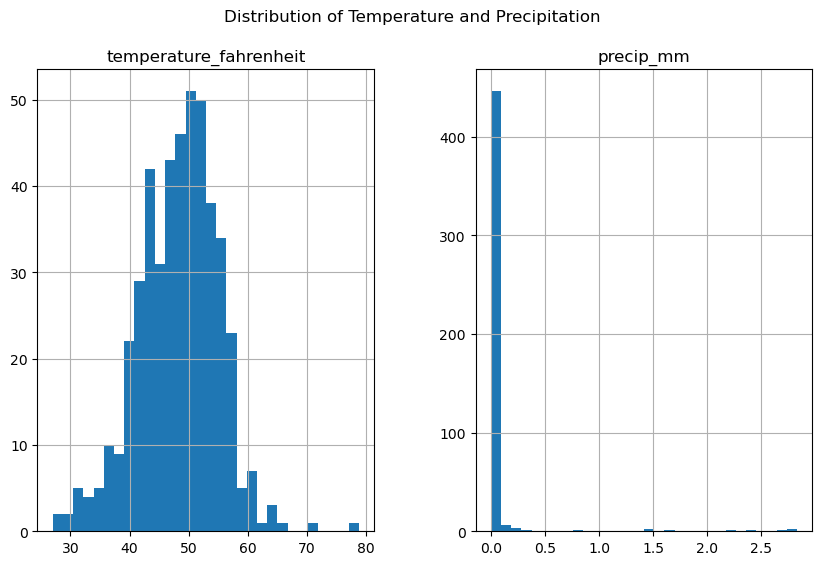

In [105]:
df_daily[['temperature_fahrenheit', 'precip_mm']].hist(bins=30, figsize=(10,6))
plt.suptitle("Distribution of Temperature and Precipitation")
plt.show()

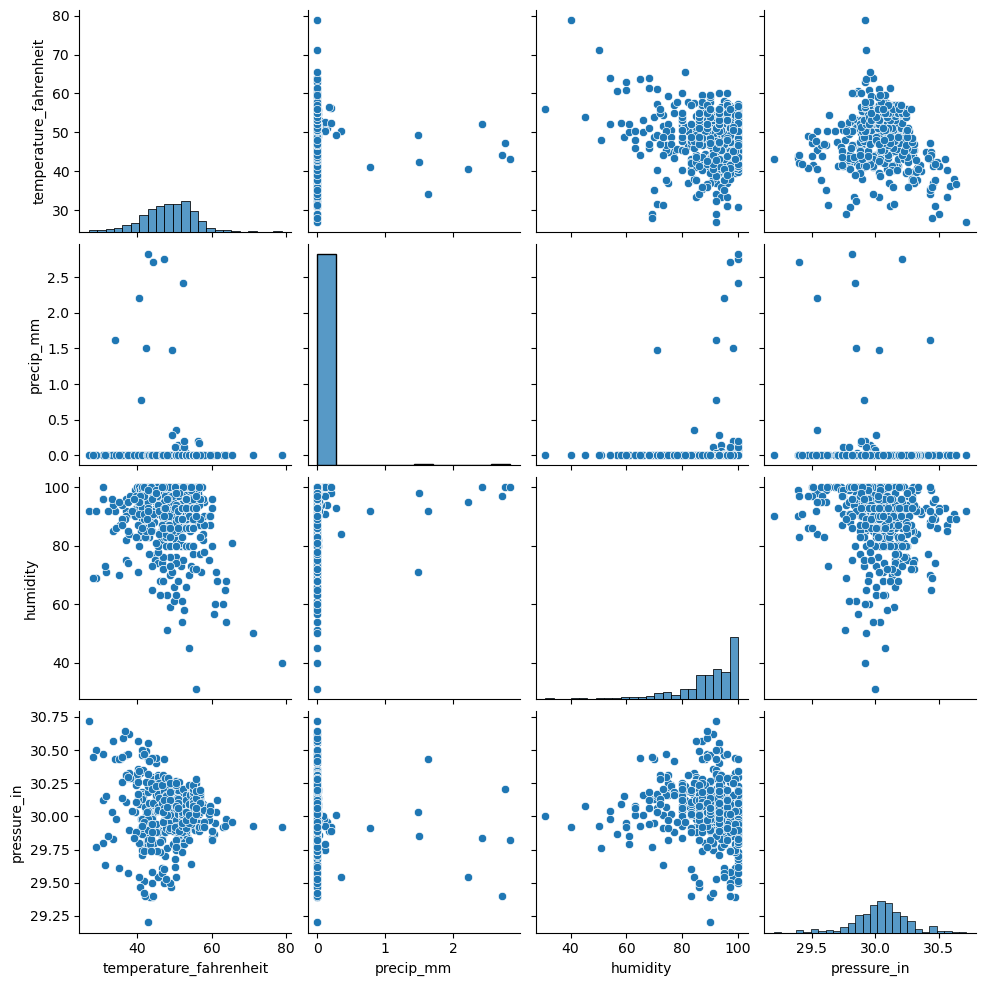

In [106]:
sns.pairplot(df_daily[['temperature_fahrenheit','precip_mm','humidity','pressure_in']])
plt.show()

* temperature is slighly negatively correlated with humidity
* precipitation is heavily zero inflated
* pressure is heavily clustered with little variability

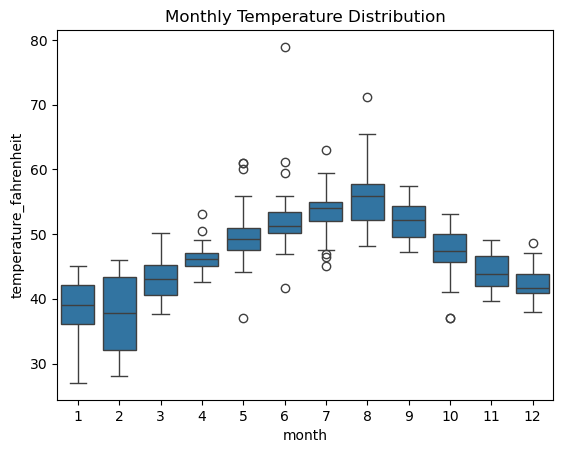

In [107]:
df_country['month'] = df_country['last_updated'].dt.month
sns.boxplot(x='month', y='temperature_fahrenheit', data=df_country.reset_index())
plt.title("Monthly Temperature Distribution")
plt.show()


* clear seasonality
* varies highly in summer months
* u shaped, warm summers and cold winters
* some extreme events outside usual range

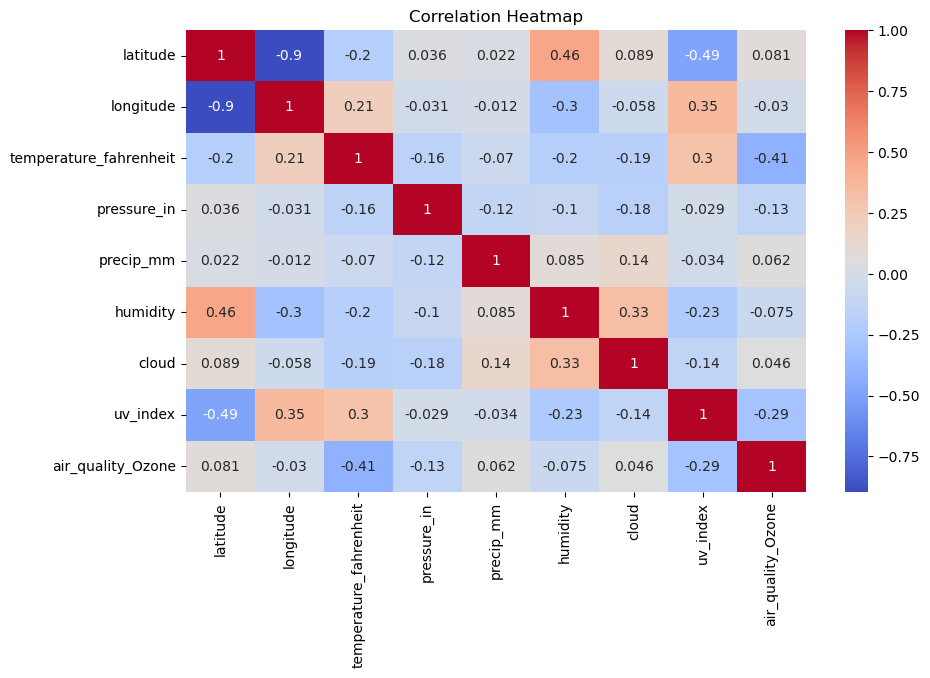

In [108]:
# correlation heatmap for daily data
numeric_cols = df_daily.select_dtypes(include='number')
plt.figure(figsize=(10,6))
sns.heatmap(numeric_cols.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

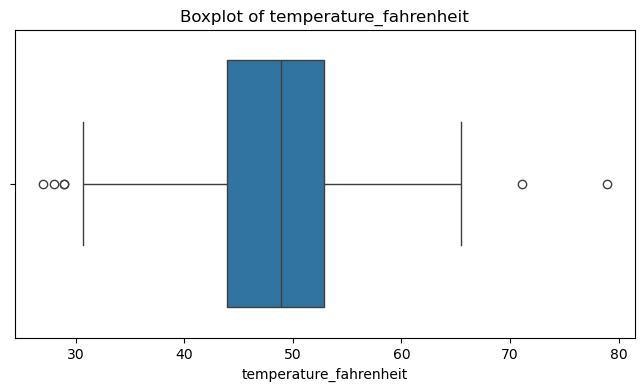

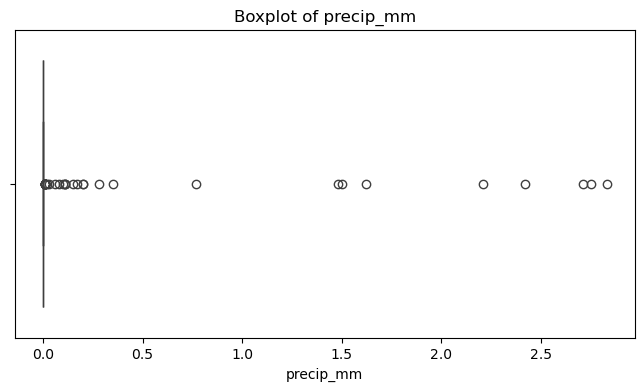

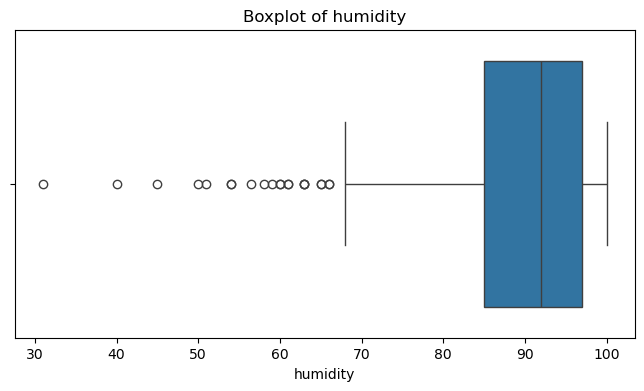

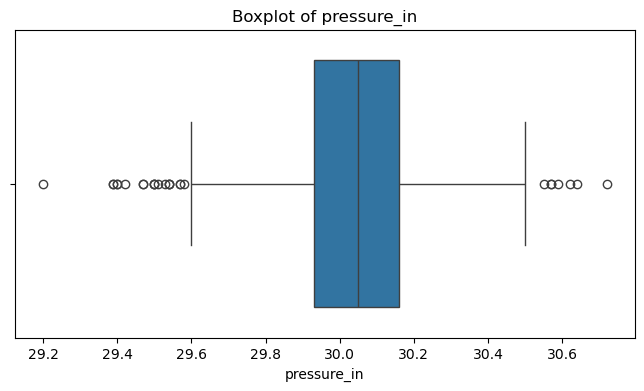

In [109]:
# visually detecting outliers
numeric_cols = ['temperature_fahrenheit', 'precip_mm', 'humidity', 'pressure_in']
for col in numeric_cols:
    plt.figure(figsize=(8,4))
    sns.boxplot(x=df_daily[col])
    plt.title(f'Boxplot of {col}')
    plt.show()


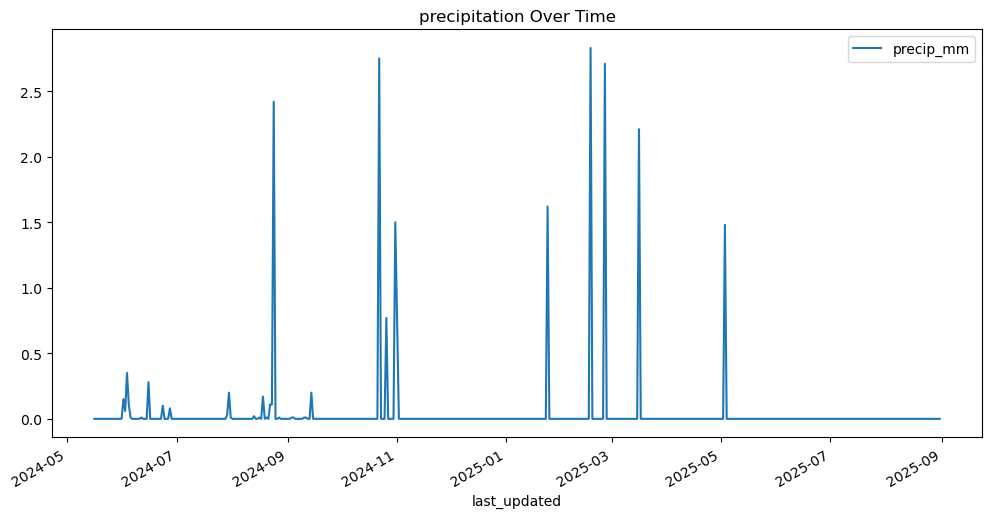

In [110]:
# precipitation over time
df_country.plot(x='last_updated', y='precip_mm', figsize=(12,6))
plt.title("precipitation Over Time")
plt.show()


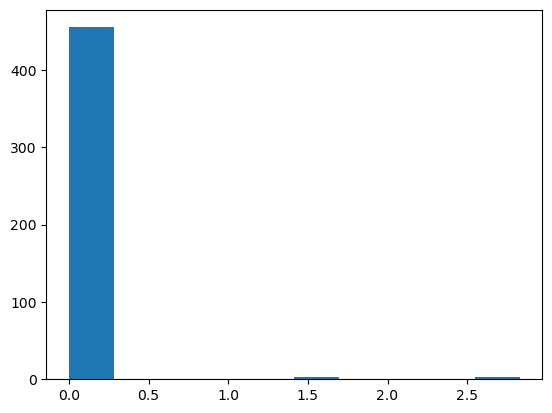

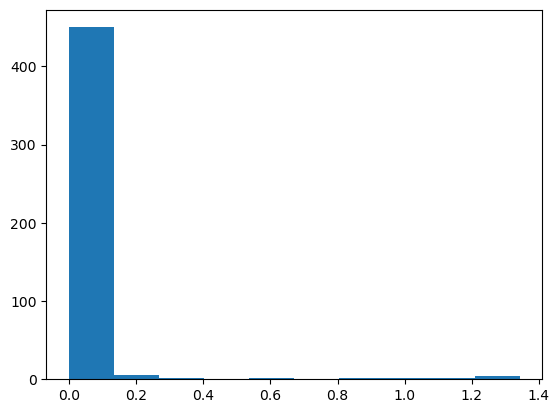

In [111]:
# handle skewness of precipitation data
import numpy as np
df_daily['log_precip'] = np.log1p(df_daily['precip_mm']) # log transform
plt.hist(df_daily.precip_mm)
plt.show()
plt.hist(df_daily.log_precip)
plt.show()

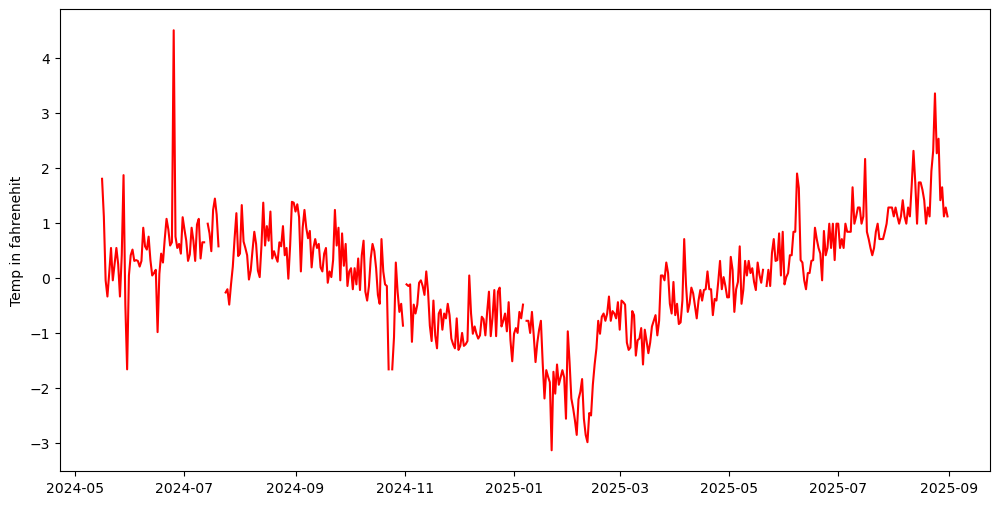

In [112]:
# visualize temperature trend
plt.figure(figsize = (12,6))
plt.plot(temp_series, color='red')
plt.ylabel("Temp in fahrenehit")
plt.show()

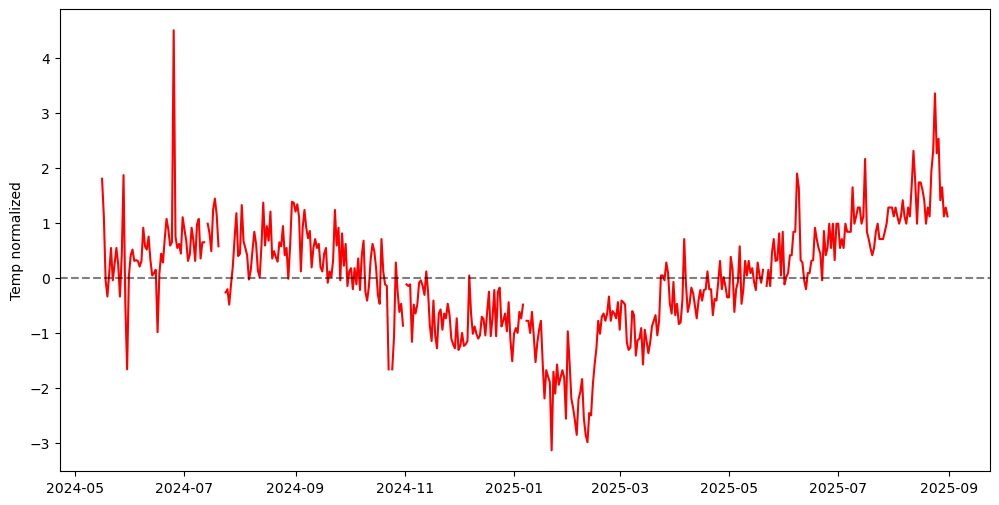

In [127]:
# Plot indicates seasonal data--> SARIMA likekly a good model to start with
# Normalize Temperature and plot it
temp_series = df_daily['temperature_fahrenheit'].sort_index()
temp_series = (temp_series - temp_series.mean()) / temp_series.std()
plt.figure(figsize = (12,6))
plt.plot(temp_series, color='red')
plt.ylabel("Temp normalized")
plt.axhline(0,linestyle='--', color='k', alpha = 0.5)
plt.show()

# Anomaly Detection

In [128]:
# Rolling median & MAD
window = 30
rolling_median = temp_series.rolling(window, center=True).median()
rolling_mad = temp_series.rolling(window, center=True).apply(
    lambda x: np.median(np.abs(x - np.median(x))), raw=True
)

# MAD-based z-score
threshold = 4 # only want to detect extreme deviations
mad_zscore = (temp_series - rolling_median) / (1.4826 * rolling_mad)
anomalies = temp_series[np.abs(mad_zscore) > threshold]
print(f"Detected {len(anomalies)} anomalies")


Detected 3 anomalies


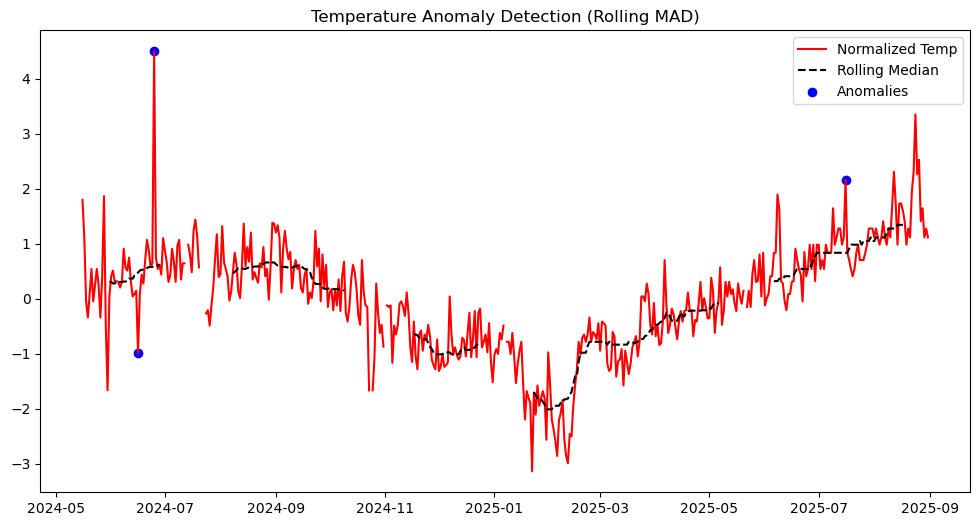

In [115]:
# Plot anomalies
plt.figure(figsize=(12, 6))
plt.plot(temp_series, color='red', label='Normalized Temp')
plt.plot(rolling_median, '--', color='black', label='Rolling Median')
plt.scatter(anomalies.index, anomalies, color='blue', label='Anomalies')
plt.legend()
plt.title('Temperature Anomaly Detection (Rolling MAD)')
plt.show()


# Stationary Check (ADF Test)

In [116]:
temp_series_clean = temp_series.interpolate(method='time')

def adf_test(series, title=''):
    """Perform Augmented Dickey-Fuller test and print results."""
    print(f'ADF Test: {title}')
    result = adfuller(series.dropna(), autolag='AIC')
    labels = ['ADF Statistic', 'p-value', '# Lags Used', '# Observations']
    for label, val in zip(labels, result[0:4]):
        print(f"{label}: {val}")
    for key, val in result[4].items():
        print(f'Critical Value ({key}): {val}')
    print("Stationary" if result[1] <= 0.05 else "Not Stationary", "\n")

# Run ADF test before and after differencing
adf_test(temp_series_clean, "Original Series")
temp_diff = temp_series_clean.diff().dropna()
adf_test(temp_diff, "After 1st Differencing")


ADF Test: Original Series
ADF Statistic: -1.1872077675089114
p-value: 0.6790742581205057
# Lags Used: 10
# Observations: 462
Critical Value (1%): -3.444583778100581
Critical Value (5%): -2.8678163032301995
Critical Value (10%): -2.570113030490433
Not Stationary 

ADF Test: After 1st Differencing
ADF Statistic: -9.341781279078196
p-value: 8.757493842089435e-16
# Lags Used: 11
# Observations: 460
Critical Value (1%): -3.44464601455782
Critical Value (5%): -2.867843681679954
Critical Value (10%): -2.570127622873346
Stationary 



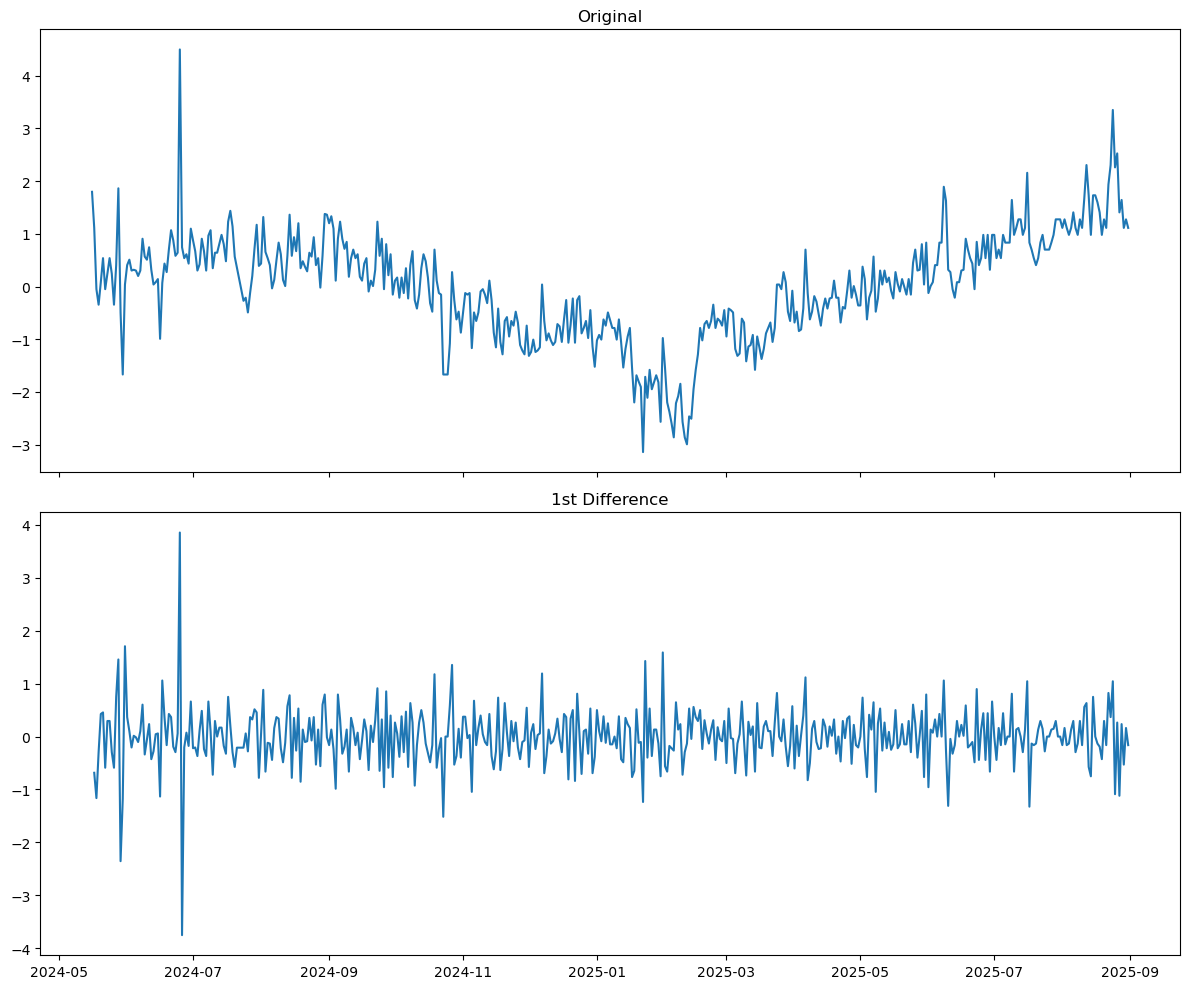

In [117]:
# Plot original vs differenced
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
axes[0].plot(temp_series_clean); axes[0].set_title("Original")
axes[1].plot(temp_diff); axes[1].set_title("1st Difference")
plt.tight_layout()
plt.show()

# SARIMA Model Selection and Training


In [118]:
stepwise_model = auto_arima(
    temp_series_clean,
    start_p=1, start_q=1,
    max_p=3, max_q=3,
    seasonal=True, m=7,  # Weekly seasonality
    start_P=0, start_Q=0,
    max_P=2, max_Q=2,
    trace=True, error_action='ignore',
    suppress_warnings=True, stepwise=True
)
print(stepwise_model.summary())



C:\Users\gadda\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\gadda\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\gadda\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\gadda\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\gadda\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\g

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=656.762, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=767.719, Time=0.07 sec


C:\Users\gadda\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\gadda\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=725.448, Time=0.21 sec


C:\Users\gadda\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=681.421, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=765.722, Time=0.03 sec


C:\Users\gadda\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\gadda\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,0,0)[7] intercept   : AIC=658.341, Time=0.53 sec


C:\Users\gadda\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=658.363, Time=0.52 sec


C:\Users\gadda\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=657.111, Time=1.06 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=679.421, Time=0.13 sec


C:\Users\gadda\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\gadda\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=725.010, Time=0.09 sec


C:\Users\gadda\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[7] intercept   : AIC=658.680, Time=0.30 sec


C:\Users\gadda\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[7] intercept   : AIC=658.645, Time=0.32 sec
 ARIMA(0,1,2)(0,0,0)[7] intercept   : AIC=658.375, Time=0.16 sec


C:\Users\gadda\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\gadda\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(0,0,0)[7] intercept   : AIC=694.034, Time=0.11 sec


C:\Users\gadda\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,0)[7] intercept   : AIC=660.492, Time=0.55 sec
 ARIMA(1,1,1)(0,0,0)[7]             : AIC=654.925, Time=0.09 sec


C:\Users\gadda\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\gadda\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,0,0)[7]             : AIC=656.503, Time=0.19 sec
 ARIMA(1,1,1)(0,0,1)[7]             : AIC=656.526, Time=0.16 sec


C:\Users\gadda\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\gadda\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,0,1)[7]             : AIC=655.212, Time=0.51 sec
 ARIMA(0,1,1)(0,0,0)[7]             : AIC=677.428, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[7]             : AIC=723.013, Time=0.04 sec


C:\Users\gadda\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\gadda\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\gadda\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[7]             : AIC=656.836, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[7]             : AIC=656.798, Time=0.16 sec


C:\Users\gadda\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\gadda\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,0,0)[7]             : AIC=656.472, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[7]             : AIC=692.035, Time=0.05 sec


C:\Users\gadda\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\gadda\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,0)[7]             : AIC=658.647, Time=0.33 sec

Best model:  ARIMA(1,1,1)(0,0,0)[7]          
Total fit time: 6.473 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  473
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -324.462
Date:                Sat, 06 Sep 2025   AIC                            654.925
Time:                        13:38:21   BIC                            667.396
Sample:                    05-16-2024   HQIC                           659.830
                         - 08-31-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3573      0.049      7.295      0.000       0.261  

In [119]:
# Train/test split
split_idx = int(len(temp_series_clean) * 0.8)
train, test = temp_series_clean.iloc[:split_idx], temp_series_clean.iloc[split_idx:]

# Fit SARIMAX
sarimax_model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(0, 0, 0, 0),
                        enforce_stationarity=False, enforce_invertibility=False)
sarimax_fit = sarimax_model.fit(disp=False)
print(sarimax_fit.summary())


                                 SARIMAX Results                                  
Dep. Variable:     temperature_fahrenheit   No. Observations:                  378
Model:                   SARIMAX(1, 1, 1)   Log Likelihood                -261.787
Date:                    Sat, 06 Sep 2025   AIC                            529.575
Time:                            13:38:21   BIC                            541.355
Sample:                        05-16-2024   HQIC                           534.252
                             - 05-28-2025                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2963      0.056      5.335      0.000       0.187       0.405
ma.L1         -0.8270      0.041    -20.197      0.000      -0.907      -0.747
sigma2         0.236

Model: SARIMAX (1,1,1)
p =1 (past temp affects current temp)
d = 1 (first differencing applied)
q = 1 (one moving avg, models noise correlation)
AR term coefficient is + 
MA term coeff is strong - (model is correcting for overestimation)

LjungBox Prob(Q) 0.79 > 0.05 (good fit since no autocorrelated residuals)
However, residuals are not normal and skewed as skew = 1.14


In [120]:
# Rolling Forecast
history = train.copy()
predictions, conf_ints = [], []

for t in range(len(test)):
    model = SARIMAX(history, order=(1, 1, 1), seasonal_order=(0, 0, 0, 0),
                    enforce_stationarity=False, enforce_invertibility=False)
    sarimax_fit = model.fit(disp=False)
    forecast = sarimax_fit.get_forecast(steps=1)
    
    predictions.append(forecast.predicted_mean.iloc[0])
    conf_ints.append(forecast.conf_int(alpha=0.05).iloc[0])
    
    # Update history with actual observation
    history = pd.concat([history, test.iloc[t:t+1]])


C:\Users\gadda\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [121]:
# Accuracy
pred_df = pd.DataFrame(predictions, index=test.index, columns=['forecast'])
rmse = np.sqrt(mean_squared_error(test, pred_df['forecast']))
mae = mean_absolute_error(test, pred_df['forecast'])
print(f'RMSE: {rmse:.3f}, MAE: {mae:.3f}')


RMSE: 0.437, MAE: 0.326


Accuracy metrics:
RMSE: .437 predictions deviate from actual temp by 0.44F on avg
MAE: 0.326 avg difference between predicted and actual temps is 0.33F

Overall, SARIMA performed very well with low RMSE and MAE and no significant autocorrelation in residuals.

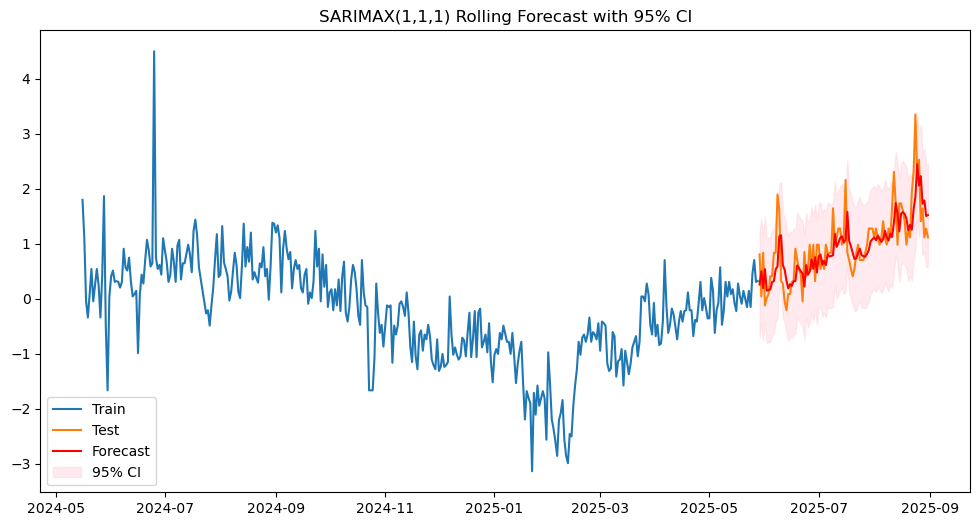

In [122]:
# Plot the forecast
plt.figure(figsize=(12,6))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(pred_df, label='Forecast', color='red')
plt.fill_between(conf_df.index, conf_df.iloc[:,0], conf_df.iloc[:,1], 
                 color='pink', alpha=0.3, label='95% CI')
plt.legend()
plt.title('SARIMAX(1,1,1) Rolling Forecast with 95% CI')
plt.show()


# XGBoost with Lag Features (Univariate)

In [123]:
def create_lag_features(series, lags=7):
    df_lags = pd.DataFrame(series)
    for lag in range(1, lags+1):
        df_lags[f'lag_{lag}'] = df_lags['temperature_fahrenheit'].shift(lag)
    return df_lags.dropna()

lagged_df = create_lag_features(temp_series_clean, lags=7)
split_idx = int(len(lagged_df) * 0.8)
X_train, y_train = lagged_df.drop('temperature_fahrenheit', axis=1), lagged_df['temperature_fahrenheit']
X_test, y_test = X_train.iloc[split_idx:], y_train.iloc[split_idx:]
X_train, y_train = X_train.iloc[:split_idx], y_train.iloc[:split_idx]

xgb_model = XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=5,
                         subsample=0.8, colsample_bytree=0.8, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

print(f"XGBoost RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.3f}, "
      f"MAE: {mean_absolute_error(y_test, y_pred):.3f}")


XGBoost RMSE: 0.636, MAE: 0.452



# XGBoost with Multivariate Lags

In [125]:
def create_multivariate_lag_features(df, features, lags=7):
    df_lags = df.copy()
    for feature in features:
        for lag in range(1, lags+1):
            df_lags[f'{feature}_lag{lag}'] = df_lags[feature].shift(lag)
    return df_lags.dropna()

features = ['temperature_fahrenheit', 'uv_index', 'humidity']
lagged_df = create_multivariate_lag_features(df_daily[features], features, lags=7)

split_idx = int(len(lagged_df) * 0.8)
train, test = lagged_df.iloc[:split_idx], lagged_df.iloc[split_idx:]
X_train, y_train = train.drop('temperature_fahrenheit', axis=1), train['temperature_fahrenheit']
X_test, y_test = test.drop('temperature_fahrenheit', axis=1), test['temperature_fahrenheit']

xgb_multi = XGBRegressor(n_estimators=500, learning_rate=0.05, max_depth=6,
                         subsample=0.8, colsample_bytree=0.8, random_state=42)
xgb_multi.fit(X_train, y_train)
y_pred = xgb_multi.predict(X_test)

print(f"Multivariate XGBoost RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.3f}, "
      f"MAE: {mean_absolute_error(y_test, y_pred):.3f}")



Multivariate XGBoost RMSE: 4.164, MAE: 2.960


<Figure size 1000x600 with 0 Axes>

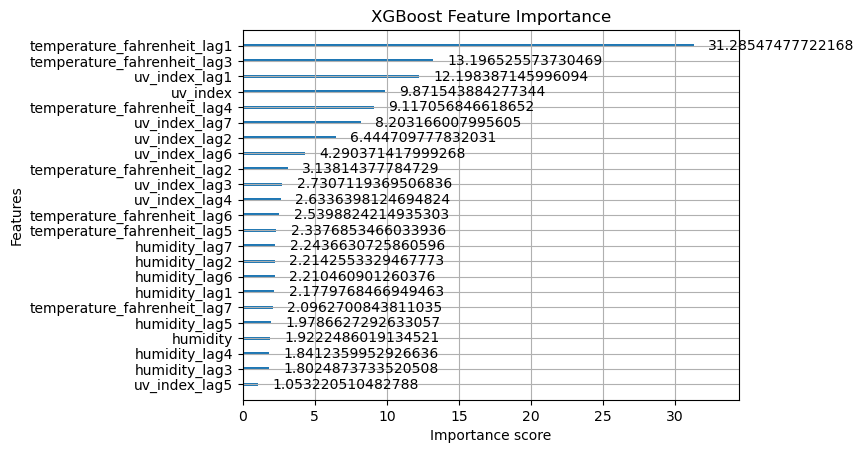

In [126]:
# Feature importance plot
plt.figure(figsize=(10, 6))
plot_importance(xgb_multi, importance_type='gain')
plt.title("XGBoost Feature Importance")
plt.show()


SARIMA best performance with lowest RMSE and MAE. 
XGboost univariate was decent but less accurate 
XGboost multivariate had poor performance likely due to overfitting/collinearity